In [105]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import logging
import warnings
from sklearn.metrics import mean_squared_error

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_excel("owid-covid-data.xlsx")
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


In [107]:


belgium_data = data[data['location'] == 'Belgium']

# Selecting the 'date' and 'new_cases' columns
belgium_data = belgium_data[['date', 'new_cases']]

# Rename the columns to 'ds' and 'y'
belgium_data.rename(columns={'date': 'ds', 'new_cases': 'y'}, inplace=True)
belgium_data['ds'] = pd.to_datetime(belgium_data['ds'])
dates_to_drop = ['2023-09-15', '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19', '2023-09-20']
belgium_data = belgium_data[~belgium_data['ds'].isin(pd.to_datetime(dates_to_drop))]

belgium_data.head(20)



,ds,y
28497,2020-01-03,0.0
28498,2020-01-04,0.0
28499,2020-01-05,0.0
28500,2020-01-06,0.0
28501,2020-01-07,0.0
28502,2020-01-08,0.0
28503,2020-01-09,0.0
28504,2020-01-10,0.0
28505,2020-01-11,0.0
28506,2020-01-12,0.0


In [96]:
print(belgium_data)

               ds    y
28497  2020-01-03  0.0
28498  2020-01-04  0.0
28499  2020-01-05  0.0
28500  2020-01-06  0.0
28501  2020-01-07  0.0
...           ...  ...
29849  2023-09-16  0.0
29850  2023-09-17  0.0
29851  2023-09-18  0.0
29852  2023-09-19  0.0
29853  2023-09-20  0.0

[1357 rows x 2 columns]


In [110]:
train=belgium_data.iloc[:-14 ]
test=belgium_data.iloc[-14: ]
print(train.shape, test.shape)

(1337, 2) (14, 2)


12:25:51 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing


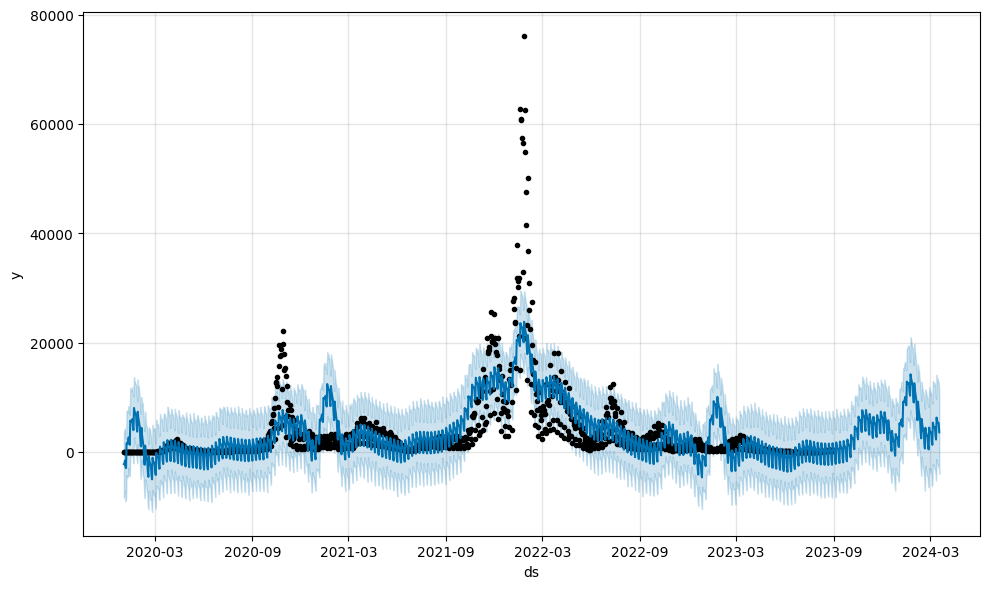

In [111]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=200)
forecast = m.predict(future)
fig = m.plot(forecast)


In [112]:
# Remove Outliers
Q1 = train['y'].quantile(0.25)
Q3 = train['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = train[(train['y'] < lower_bound) | (train['y'] > upper_bound)]

train.loc[train['y'] < lower_bound, 'y'] = None
train.loc[train['y'] > upper_bound, 'y'] = None



In [113]:
m = Prophet()
m.add_country_holidays(country_name='Belgium')
m.fit(train)
m.train_holiday_names

12:27:06 - cmdstanpy - INFO - Chain [1] start processing
12:27:07 - cmdstanpy - INFO - Chain [1] done processing


0         New Year's Day
1                 Easter
2          Easter Monday
3              Labor Day
4          Ascension Day
5            Whit Sunday
6            Whit Monday
7           National Day
8     Assumption of Mary
9        All Saints' Day
10         Armistice Day
11         Christmas Day
dtype: object

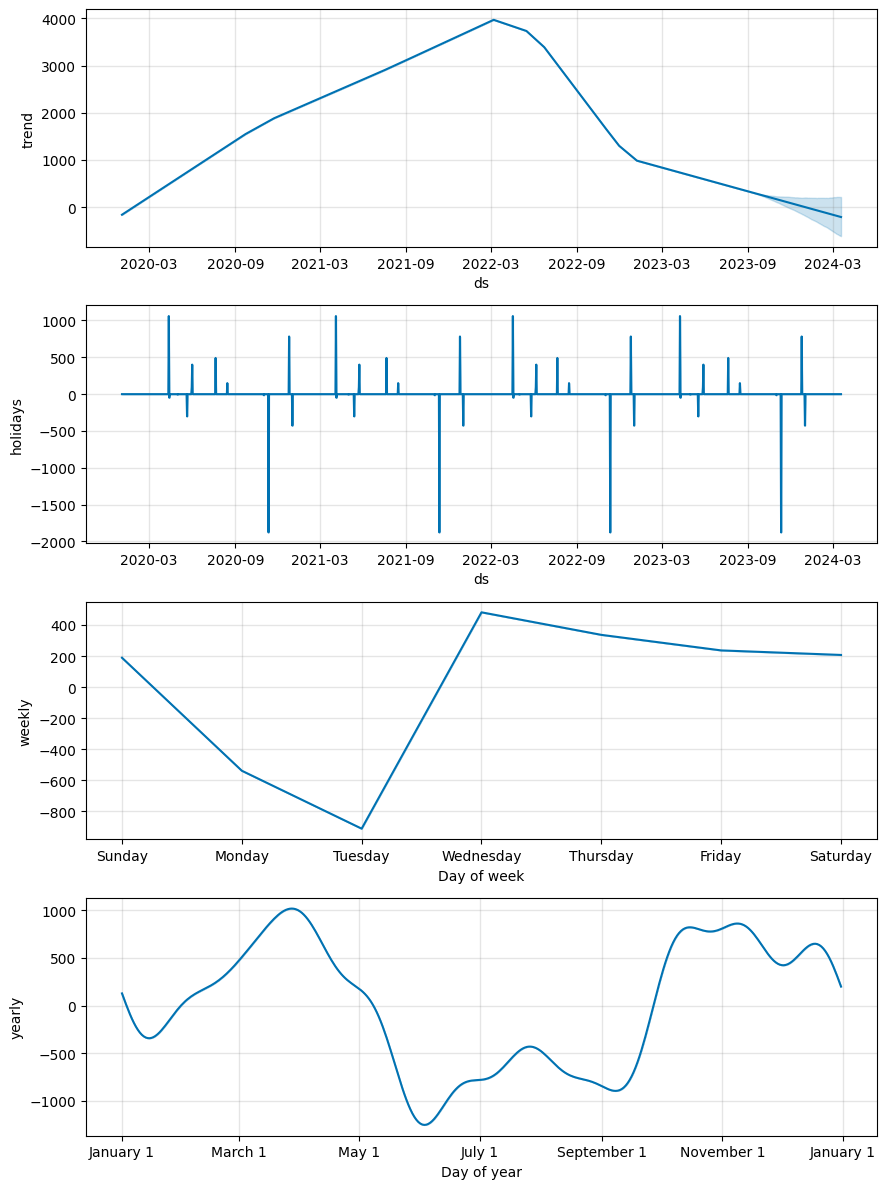

In [114]:
forecast = m.predict(future)
fig = m.plot_components(forecast)


In [115]:
train_pred=m.predict(train).set_index('ds')
train_pred.head()


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Armistice Day,Armistice Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-163.306270,-1177.736023,1459.000179,-163.306270,-163.306270,0.0,0.0,0.0,0.0,0.0,...,236.189940,236.189940,236.189940,55.993526,55.993526,55.993526,0.0,0.0,0.0,128.877196
2020-01-04,-156.819074,-1318.372970,1383.784741,-156.819074,-156.819074,0.0,0.0,0.0,0.0,0.0,...,206.972135,206.972135,206.972135,0.661348,0.661348,0.661348,0.0,0.0,0.0,50.814409
2020-01-05,-150.331878,-1301.247184,1343.394812,-150.331878,-150.331878,0.0,0.0,0.0,0.0,0.0,...,188.920766,188.920766,188.920766,-52.452800,-52.452800,-52.452800,0.0,0.0,0.0,-13.863912
2020-01-06,-143.844682,-2109.208661,612.523948,-143.844682,-143.844682,0.0,0.0,0.0,0.0,0.0,...,-538.480915,-538.480915,-538.480915,-102.625236,-102.625236,-102.625236,0.0,0.0,0.0,-784.950833
2020-01-07,-137.357486,-2423.573575,149.471241,-137.357486,-137.357486,0.0,0.0,0.0,0.0,0.0,...,-911.388587,-911.388587,-911.388587,-149.198450,-149.198450,-149.198450,0.0,0.0,0.0,-1197.944523


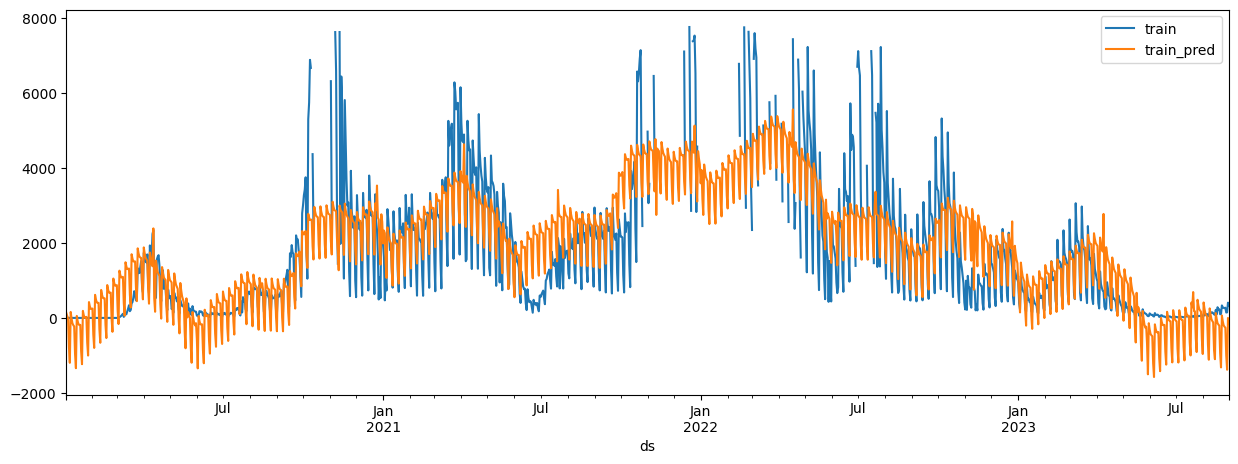

In [116]:
pd.concat([train.set_index('ds'),train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

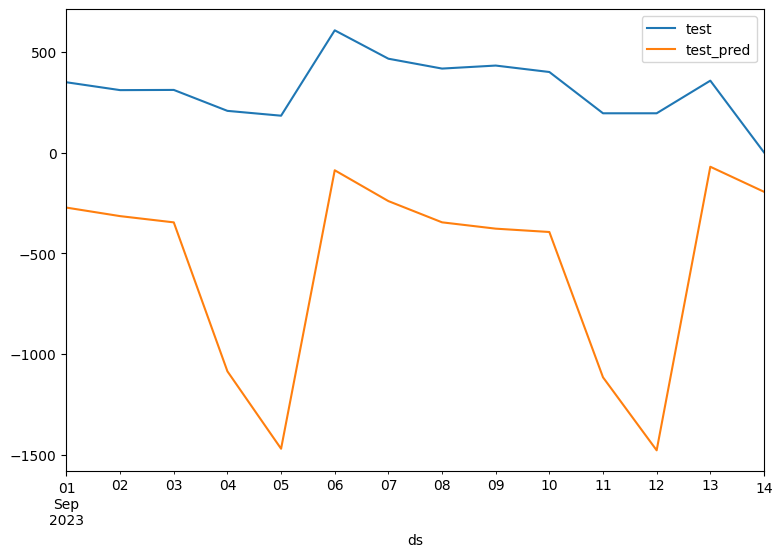

In [117]:
test_pred=m.predict(test).set_index('ds')
pd.concat([test.set_index('ds'),test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [118]:
test_rmse = np.sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 971.6166274972451


In [131]:
# Belgium had two lockdowns
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-04-08', 'lower_window': 0, 'ds_upper': '2020-05-2'},
    {'holiday': 'lockdown_2', 'ds': '2020-08-30', 'lower_window': 0, 'ds_upper': '2021-04-01'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
holidays = pd.concat((lockdowns, us_holidays))
holidays = holidays.reset_index()
holidays.loc[2:, 'ds_upper'] = holidays.loc[2:, 'ds'] + pd.Timedelta(days=7)
holidays.head()


,index,holiday,ds,lower_window,ds_upper,upper_window
0,0,lockdown_1,2020-04-08,0.0,2020-05-02,24.0
1,1,lockdown_2,2020-08-30,0.0,2021-04-01,214.0
2,0,Martin Luther King Jr. Day,2020-01-20,NaN,2020-01-27,NaN
3,1,Washington's Birthday,2020-02-17,NaN,2020-02-24,NaN
4,2,Columbus Day,2020-10-12,NaN,2020-10-19,NaN


In [132]:
m2 = Prophet(holidays=holidays,
             n_changepoints = 100,
             changepoint_prior_scale = 0.1,
             seasonality_mode = 'multiplicative'
             )
m2.fit(train)

13:14:30 - cmdstanpy - INFO - Chain [1] start processing
13:14:34 - cmdstanpy - INFO - Chain [1] done processing


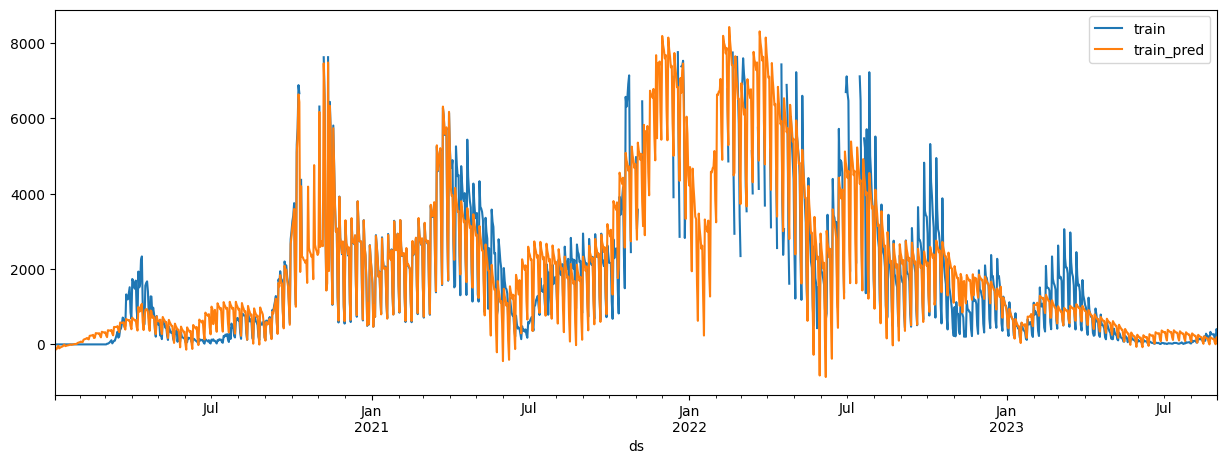

In [133]:
train_pred=m2.predict(train).set_index('ds')
pd.concat([train.set_index('ds'),train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

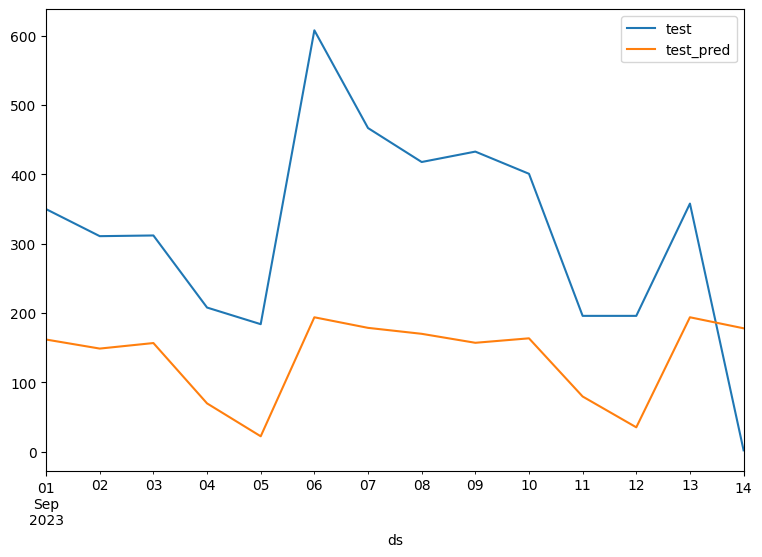

In [124]:
test_pred=m2.predict(test).set_index('ds')
pd.concat([test.set_index('ds'),test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [125]:
test_rmse = np.sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 219.87818044238094


In [129]:
pip install fbprophet


  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.7.0-py3-none-any.whl (13 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Obtaining dependency information for ephem>=3.7.5.3 from https://files.pythonhosted.org/packages/eb/a8/dc9e99453ae6c959e810f4329ac3d66f8a9f447911928cca88fd2ca1c3c9/ephem-4.1.5-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Using cached ephem-4.1.5-cp311-cp311-macosx_10_9_x86_64.whl.metadata (6.0 kB)
  Obtaining dependency information for aiohttp<4.0,>=3.6 from https://files.pythonhosted.org/packages/0b/f7/6fce2fa9c9352c2b0a9868cbd6aaab57a46fa52330e90c0fa0cdf990cec0/aiohttp